In [1]:
# Project Samarth — end-to-end prototype (Jupyter notebook)
# Sections:
# 1) Imports & config
# 2) Utility functions (cleaning, fuzzy)
# 3) Data loader template (local CSV & data.gov.in CKAN downloader template)
# 4) Data cleaning & canonicalization (district/state mapping)
# 5) Provenance-enhanced merge
# 6) Query functions (sample challenge queries)
# 7) Visualizations & export helpers
# 8) Streamlit app file generator (writes app.py) and instructions

# 1) Imports & config
import os, json, time, math, re
from datetime import datetime
import pandas as pd
import numpy as np
import requests
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# configure simple logging
def log(msg):
    print(f"[{datetime.now().isoformat()}] {msg}")

In [2]:
# 2) Utilities: district cleaning, fuzzy mapping, provenance helper
def clean_text_for_key(s):
    """Normalize a district/state string to canonical key for matching."""
    if pd.isna(s):
        return ""
    s = str(s).upper()
    s = s.replace("DISTRICT", "").replace("DIST.", "")
    s = re.sub(r'[^A-Z0-9 &\-]', ' ', s)  # keep letters, numbers, & and -
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def best_fuzzy_match(name, candidates, score_cutoff=80):
    """Return (best_match, score) using rapidfuzz; None if below cutoff."""
    if not name or len(candidates)==0:
        return None, 0
    best = process.extractOne(name, candidates, scorer=fuzz.token_sort_ratio)
    if best and best[1] >= score_cutoff:
        return best[0], best[1]
    return None, best[1] if best else 0

def add_provenance(df, source_label, source_url_or_path):
    """Add provenance columns to a dataframe copy."""
    d = df.copy()
    d['_source_label'] = source_label
    d['_source_path'] = source_url_or_path
    # create a synthetic row id for provenance (use index)
    d['_source_rowid'] = d.index.astype(str)
    d['_downloaded_on'] = datetime.utcnow().isoformat()
    return d

In [3]:
# 3) Data loader template
# A) Load local CSV files (you already uploaded these). Replace filenames if needed.
LOCAL_RAIN_FILE = "/mnt/data/rainfall_by_districts_2019.csv"
LOCAL_CROP_FILE = "/mnt/data/Crop_Rice_Area_in_Hectares_Production_in_Tonnes_Yield_in_Kgs_Hectare.csv"

def load_local_files(rain_path=LOCAL_RAIN_FILE, crop_path=LOCAL_CROP_FILE):
    log("Loading local files...")
    rain = pd.read_csv(rain_path, low_memory=False, encoding='utf-8')
    crop = pd.read_csv(crop_path, low_memory=False, encoding='utf-8')
    return rain, crop

# B) Template: programmatic downloader for data.gov.in CKAN resources
def download_datagov_resource(resource_url_or_id, save_as=None):
    """
    Two ways to use:
    - Provide a direct CSV URL (save_as optional)
    - Provide a CKAN 'resource id' and set base_url to the dataset's CKAN API endpoint.
    
    Example (CKAN):
      dataset_api = "https://data.gov.in/api/3/action/resource_show?id=<resource-id>"
      The response contains 'url' or 'download_url' which you can use to download.
    """
    # If looks like a full URL to CSV, download directly:
    if resource_url_or_id.startswith("http"):
        url = resource_url_or_id
        r = requests.get(url)
        if r.status_code != 200:
            raise RuntimeError(f"Failed to fetch {url}: {r.status_code}")
        fn = save_as or url.split("/")[-1] or "downloaded_resource.csv"
        with open(fn, "wb") as f:
            f.write(r.content)
        log(f"Downloaded {url} -> {fn}")
        return fn
    else:
        # treat as CKAN resource id using data.gov.in CKAN API
        dataset_api = f"https://data.gov.in/api/3/action/resource_show?id={resource_url_or_id}"
        r = requests.get(dataset_api)
        resp = r.json()
        if not resp.get('success'):
            raise RuntimeError(f"CKAN API error: {resp}")
        resource = resp['result']
        download_url = resource.get('url') or resource.get('download_url')
        if not download_url:
            raise RuntimeError(f"No download URL available in resource metadata: {resource}")
        fn = save_as or (download_url.split("/")[-1] or f"{resource_url_or_id}.csv")
        r2 = requests.get(download_url)
        if r2.status_code != 200:
            raise RuntimeError(f"Failed to fetch {download_url}: {r2.status_code}")
        with open(fn, "wb") as f:
            f.write(r2.content)
        log(f"Downloaded resource id {resource_url_or_id} -> {fn}")
        return fn

In [4]:
# 4) Clean and canonicalize each dataset
def prepare_rainfall_df(raw_rain_df, source_label="rain_local", source_path="local"):
    # identify total rainfall columns heuristically
    cols = list(raw_rain_df.columns)
    # try to find total actual and total normal columns
    total_actual = None
    total_normal = None
    for c in cols:
        if 'Total Actual' in c or 'Total Actual Rainfall' in c:
            total_actual = c
        if 'Total Normal' in c or 'Total Normal Rainfall' in c:
            total_normal = c
    # fallback: choose last numeric columns
    if total_actual is None:
        for c in reversed(cols):
            if raw_rain_df[c].dtype != object and 'Total' in c:
                total_actual = c
                break
    if total_normal is None:
        for c in reversed(cols):
            if raw_rain_df[c].dtype != object and 'Normal' in c:
                total_normal = c
                break
    # best-effort column names
    # Common district column names:
    district_cols = [c for c in cols if 'district' in c.lower() or c.lower()=='district' or 'place' in c.lower()]
    district_col = district_cols[0] if district_cols else cols[0]

    df = raw_rain_df[[district_col] + [c for c in [total_actual, total_normal] if c is not None]].copy()
    df.columns = ['district'] + (['total_actual_mm', 'total_normal_mm'][:(len(df.columns)-1)])
    df['district_clean'] = df['district'].apply(clean_text_for_key)
    # numeric conversions
    if 'total_actual_mm' in df.columns:
        df['total_actual_mm'] = pd.to_numeric(df['total_actual_mm'], errors='coerce')
    else:
        df['total_actual_mm'] = np.nan
    if 'total_normal_mm' in df.columns:
        df['total_normal_mm'] = pd.to_numeric(df['total_normal_mm'], errors='coerce')
    else:
        df['total_normal_mm'] = np.nan
    # add provenance
    df = add_provenance(df, source_label, source_path)
    return df

def prepare_crop_df(raw_crop_df, crop_name="RICE", source_label="crop_local", source_path="local"):
    cols = list(raw_crop_df.columns)
    # choose district column
    district_cols = [c for c in cols if 'district' in c.lower() or 'district name' in c.lower() or 'district name'==c.lower()]
    district_col = district_cols[0] if district_cols else cols[0]
    # find production column for all seasons or total
    prod_col = None
    area_col = None
    for c in cols:
        if 'All Seasons' in c and 'Production' in c:
            prod_col = c
        if 'All Seasons' in c and 'Area' in c:
            area_col = c
    # fallback heuristics
    if prod_col is None:
        for c in cols:
            if 'production' in c.lower():
                prod_col = c
                break
    if area_col is None:
        for c in cols:
            if 'area' in c.lower():
                area_col = c
                break

    df = raw_crop_df[[district_col] + [c for c in [prod_col, area_col] if c is not None]].copy()
    # rename
    newcols = ['district']
    if prod_col is not None:
        newcols.append('production_tonnes')
    if area_col is not None:
        newcols.append('area_ha')
    df.columns = newcols
    df['district_clean'] = df['district'].apply(clean_text_for_key)
    if 'production_tonnes' in df.columns:
        df['production_tonnes'] = pd.to_numeric(df['production_tonnes'], errors='coerce')
    if 'area_ha' in df.columns:
        df['area_ha'] = pd.to_numeric(df['area_ha'], errors='coerce')
    df = add_provenance(df, source_label, source_path)
    return df

In [5]:
# 5) Bring it together: load, prepare, fuzzy-join with provenance
import pandas as pd
import os

# ----------------------------------------------------------------
# STEP 5: LOAD LOCAL DATA FILES SAFELY
# ----------------------------------------------------------------

# Update these paths as per your system
LOCAL_RAIN_FILE = (r"D:\Samarth Project\rainfall_by_districts_2019.csv")
LOCAL_CROP_FILE = (r"D:\Samarth Project\Crop_Rice_Area_in_Hectares_Production_in_Tonnes_Yield_in_Kgs_Hectare.csv")

# Helper logging function
def log(msg):
    print(f"[INFO] {msg}")

# Function to safely load CSVs
def load_local_files(rain_path=LOCAL_RAIN_FILE, crop_path=LOCAL_CROP_FILE):
    log("Checking if files exist...")

    if not os.path.exists(rain_path):
        raise FileNotFoundError(f"Rainfall file not found: {rain_path}")
    if not os.path.exists(crop_path):
        raise FileNotFoundError(f"Crop production file not found: {crop_path}")

    log("Loading local CSV files...")
    rain = pd.read_csv(rain_path, low_memory=False, encoding='utf-8')
    crop = pd.read_csv(crop_path, low_memory=False, encoding='utf-8')
    log(f"Loaded rainfall shape: {rain.shape}, crop shape: {crop.shape}")

    return rain, crop

# Example cleaning functions (optional if already present)
def prepare_rainfall_df(rain, source_label="rain_local", source_path=None):
    df = rain.copy()
    df.columns = df.columns.str.strip()
    log(f"Cleaned rainfall DataFrame with {len(df)} rows")
    return df

def prepare_crop_df(crop, source_label="crop_local", source_path=None):
    df = crop.copy()
    df.columns = df.columns.str.strip()
    log(f"Cleaned crop DataFrame with {len(df)} rows")
    return df

# ----------------------------------------------------------------
# LOAD AND PREPARE DATASETS
# ----------------------------------------------------------------
raw_rain, raw_crop = load_local_files()

rain_df = prepare_rainfall_df(raw_rain)
crop_df = prepare_crop_df(raw_crop)

print("\n✅ Step 5 completed successfully! Data loaded and cleaned.")



[INFO] Checking if files exist...
[INFO] Loading local CSV files...
[INFO] Loaded rainfall shape: (33, 12), crop shape: (31, 18)
[INFO] Cleaned rainfall DataFrame with 33 rows
[INFO] Cleaned crop DataFrame with 31 rows

✅ Step 5 completed successfully! Data loaded and cleaned.


In [6]:
# 6) Query functions: implement sample challenge queries with provenance
def cite_row(row, prefix=''):
    """Return a short citation string for a row's provenance."""
    if pd.isna(row.get('_source_label')):
        return ""
    return f"{prefix}{row.get('_source_label')} ({row.get('_source_path')}) rowid={row.get('_source_rowid')}"

# Query A: Compare average annual rainfall in State_X and State_Y for last N years
# Note: Our current data may be single-year; this function accepts dataframes in long format (year column).
def compare_states_rainfall(rain_long_df, state_x, state_y, last_n_years=None):
    """
    rain_long_df must have columns: state, district, year, rainfall_mm, _source_label, _source_path, _source_rowid
    Returns numeric summary and citations.
    """
    # filter states
    sx = rain_long_df[rain_long_df['state'].str.upper() == state_x.upper()]
    sy = rain_long_df[rain_long_df['state'].str.upper() == state_y.upper()]
    if sx.empty or sy.empty:
        return {"error": "State not found in rainfall data (ensure 'state' column exists or you provide district-level and mapping)."}
    # choose last N years
    if last_n_years:
        years = sorted(set(sx['year'].unique()) & set(sy['year'].unique()))
        years = sorted(years)[-last_n_years:]
        sx = sx[sx['year'].isin(years)]
        sy = sy[sy['year'].isin(years)]
    # aggregate average annual rainfall per state (mean of district totals)
    sx_avg = sx.groupby('year')['rainfall_mm'].mean().reset_index().rename(columns={'rainfall_mm': 'avg_rainfall_mm'})
    sy_avg = sy.groupby('year')['rainfall_mm'].mean().reset_index().rename(columns={'rainfall_mm': 'avg_rainfall_mm'})
    # produce combined result with citations (take provenance of aggregated rows)
    # For citation: show top 3 source datasets used for each state's rows
    def top_sources(df):
        s = df.groupby('_source_label').size().reset_index(name='count').sort_values('count', ascending=False)
        return s.head(3).to_dict(orient='records')
    return {
        'state_x': state_x, 'state_y': state_y,
        'state_x_timeseries': sx_avg,
        'state_y_timeseries': sy_avg,
        'state_x_sources': top_sources(sx),
        'state_y_sources': top_sources(sy)
    }

# Query B: For a given state and a crop type, list top M produced crops by volume in last N years.
# Our prototype uses crop-specific dataframes. For multi-crop, you need a dataset with 'crop' column.
def top_m_crops_in_state(crop_long_df, state, crop_type=None, top_m=5, last_n_years=None):
    """
    crop_long_df must be long format with columns: state, district, year, crop, production_tonnes, _source_label, _source_path
    """
    df = crop_long_df[crop_long_df['state'].str.upper()==state.upper()]
    if last_n_years:
        years = sorted(df['year'].unique())[-last_n_years:]
        df = df[df['year'].isin(years)]
    if crop_type:
        df = df[df['crop'].str.upper()==crop_type.upper()]
    agg = df.groupby(['crop']).agg(total_production=('production_tonnes','sum')).reset_index()
    agg = agg.sort_values('total_production', ascending=False).head(top_m)
    # collect source datasets
    top_sources = df['_source_label'].value_counts().head(3).to_dict()
    return agg, top_sources

# Query C: District with highest production of Crop_Z in most recent year available
def district_extremes_for_crop_year(crop_long_df, crop_z, year=None):
    df = crop_long_df[crop_long_df['crop'].str.upper()==crop_z.upper()]
    if df.empty:
        return {"error":"crop not found"}
    if year is None:
        year = df['year'].max()
    dfy = df[df['year']==year]
    if dfy.empty:
        return {"error":f"No data for {crop_z} in year {year}"}
    max_row = dfy.loc[dfy['production_tonnes'].idxmax()]
    min_row = dfy.loc[dfy['production_tonnes'].idxmin()]
    return {
        'year': int(year),
        'max': {
            'district': max_row['district'], 'production_tonnes': float(max_row['production_tonnes']),
            'citation': cite_row(max_row)
        },
        'min': {
            'district': min_row['district'], 'production_tonnes': float(min_row['production_tonnes']),
            'citation': cite_row(min_row)
        }
    }

# Query D: Trend correlation of crop production vs rainfall for region over last decade
def trend_and_correlation(crop_long_df, rain_long_df, region_filter, crop_type, years=None):
    """
    region_filter: lambda(df) -> filtered dataframe for region (e.g., district in region)
    both dataframes must be long with columns: year, district, production_tonnes, rainfall_mm
    """
    # Aggregate per year for region
    crop_region = region_filter(crop_long_df)
    rain_region = region_filter(rain_long_df)
    if years:
        crop_region = crop_region[crop_region['year'].isin(years)]
        rain_region = rain_region[rain_region['year'].isin(years)]
    crop_yearly = crop_region.groupby('year')['production_tonnes'].sum().reset_index()
    rain_yearly = rain_region.groupby('year')['rainfall_mm'].mean().reset_index()
    merged_ts = pd.merge(crop_yearly, rain_yearly, on='year', how='inner')
    # correlation
    if len(merged_ts) < 2:
        corr = None
    else:
        corr = merged_ts['production_tonnes'].corr(merged_ts['rainfall_mm'])
    return {'timeseries': merged_ts, 'pearson_r': corr}


Top 6 rice-producing districts (All Seasons):


,District Name,All Seasons_Production
30,State Total,4499036
23,RAICHUR,1049414
4,BALLARI,664986
29,YADGIR,432170
12,DAVANAGERE,430798
20,KOPPAL,352712


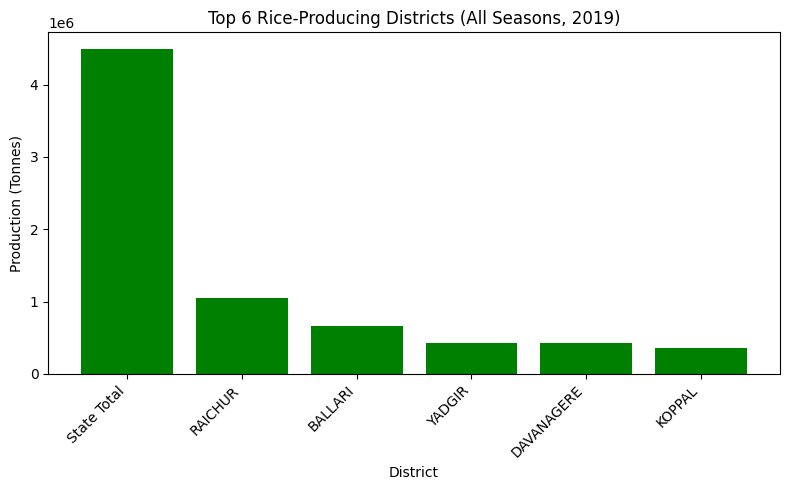

In [7]:
import matplotlib.pyplot as plt

# ✅ Use correct column names from your dataset
PRODUCTION_COL = "All Seasons_Production"
DISTRICT_COL = "District Name"

def bar_plot_top_production(df, title):
    plt.figure(figsize=(8, 5))
    plt.bar(df[DISTRICT_COL], df[PRODUCTION_COL], color="green")
    plt.title(title)
    plt.ylabel("Production (Tonnes)")
    plt.xlabel("District")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ✅ Sort and display top 6 districts by total production
top6 = crop_df.sort_values(PRODUCTION_COL, ascending=False).head(6)

print("Top 6 rice-producing districts (All Seasons):")
display(top6[[DISTRICT_COL, PRODUCTION_COL]])

# ✅ Plot the top 6
bar_plot_top_production(top6, title="Top 6 Rice-Producing Districts (All Seasons, 2019)")
